# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax, Input

import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.backend import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
    Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model


![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
print(train['X'].shape)
print(train['y'].shape)
print(test['X'].shape)
print(test['y'].shape)

(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 26032)
(26032, 1)


In [4]:
train_X = np.array(train['X']).astype('float64') / 255.0 # Scale to 0 - 1.0
num_train_elements = train_X.shape[3]
train_X = np.moveaxis(train_X, -1, 0) # Move the last dimension to the first
train_y_sparse = np.array(train['y'])
train_y_sparse = train_y_sparse.reshape((num_train_elements)) # Remove nested dimension
# train_y = one_hot(train_y, 10)
train_y = to_categorical(train_y_sparse, 11) # Convert to one hot encoding
train_y = train_y[:,1:] # Remove 0th column since categories are 1 - 10
test_X = np.array(test['X']).astype('float64') / 255.0 # Scale to 0 - 1.0
num_test_elements = test_X.shape[3]
test_X = np.moveaxis(test_X, -1, 0) # Move the last dimension to the first
test_y_sparse = np.array(test['y'])
test_y_sparse = test_y_sparse.reshape((num_test_elements)) # Remove nested dimension
test_y = to_categorical(test_y_sparse, 11) # Convert to one hot encoding
test_y = test_y[:,1:] # Remove 0th column since categories are 1 - 10





def print_label(y_label):
    m = 1
    for n in y_label:
        if n == 1:
            print(f"Label {m}")
        m += 1
# Select a random sample of images and 
# corresponding labels from the dataset 
# (at least 10), and display them in a figure.
def print_random_samples(num_samples, data_X, 
                         data_y, data_y_sparse):
    num_elements = data_y.shape[0]
    for i in range(0,num_samples):
        n = random.randint(1,num_elements-1)
        img = data_X[n, :, :, :]
        print(f"Sample {n}, Label {data_y_sparse[n]}")
        if img.shape[2] == 1:
            plt.imshow(img[:, :, 0], cmap='gray')
        else:
            plt.imshow(img)
        plt.show()


Sample 57365, Label 2


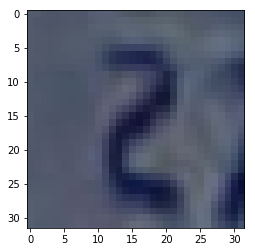

Sample 59845, Label 4


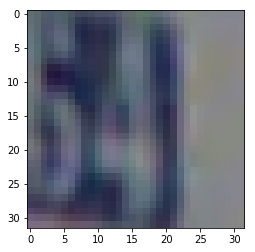

Sample 55785, Label 5


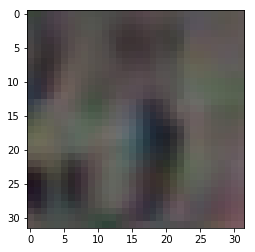

Sample 5052, Label 8


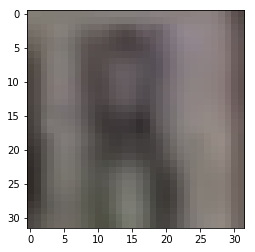

Sample 21402, Label 3


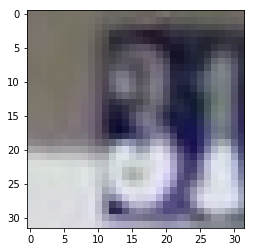

Sample 6193, Label 10


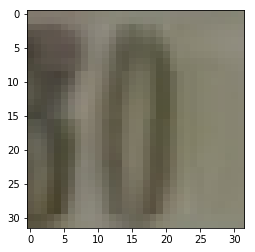

Sample 19994, Label 1


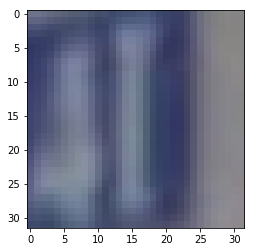

Sample 58882, Label 5


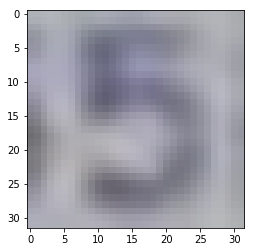

Sample 56757, Label 6


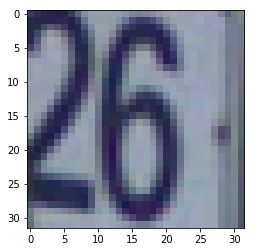

Sample 33242, Label 7


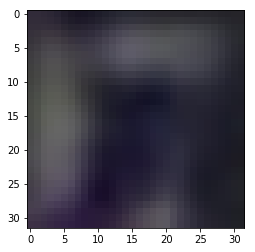

In [5]:
print_random_samples(10, train_X, train_y, train_y_sparse)

In [10]:
def transform_data(in_data_X, in_data_y, num_elements):
    res_X = np.full((num_elements, 32, 32, 1), 0.0)
    i = 0
    while i < num_elements:
        img = in_data_X[i, :, :, :]
        img_gray = np.mean(img, axis=2,keepdims=1)
        res_X[i] = img_gray
        i += 1
    return res_X, in_data_y


In [11]:
(train_X, train_y) = transform_data(train_X, train_y, num_train_elements)
(test_X, test_y) = transform_data(test_X, test_y, num_test_elements)


In [12]:
train_X.shape


(73257, 32, 32, 1)

Sample 5413, Label 8


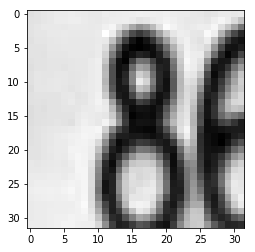

Sample 18634, Label 3


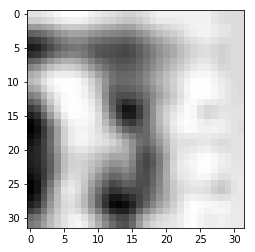

Sample 66725, Label 2


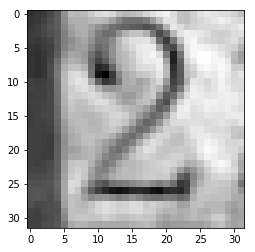

Sample 47700, Label 2


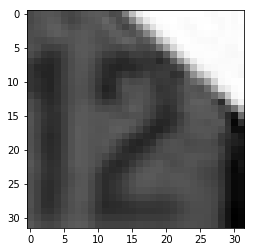

Sample 4500, Label 1


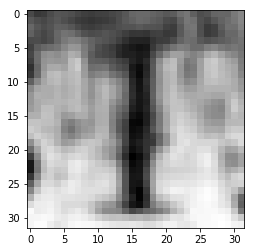

Sample 63122, Label 1


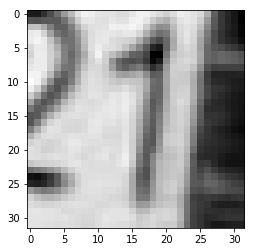

Sample 5587, Label 3


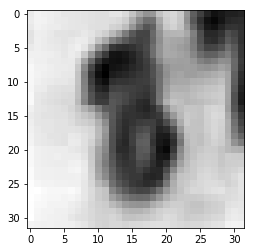

Sample 2269, Label 1


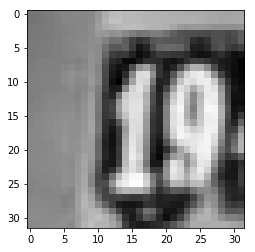

Sample 4615, Label 1


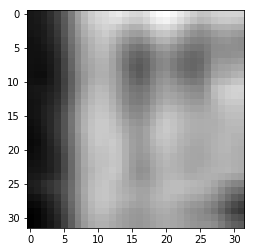

Sample 10065, Label 8


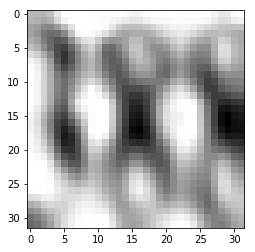

In [13]:
print_random_samples(10, train_X, train_y, train_y_sparse)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [14]:
model = Sequential([
    Flatten(input_shape=(32,32,1), name="layer_1"),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005), name="layer_2"),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005), name="layer_3"),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005), name="layer_4"),
    Dense(10, activation='softmax', name="output_layer")
])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Flatten)            (None, 1024)              0         
_________________________________________________________________
layer_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
layer_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
layer_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
output_layer (Dense)         (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy', 'mae'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback, Callback, ReduceLROnPlateau
best_model_checkpoint = ModelCheckpoint('best_model', 
                             save_weights_only=True,
                             save_best_only=True, 
                             monitor='accuracy')
early_stopping_callback = EarlyStopping(monitor='accuracy', patience=2)


In [17]:
epoch_end_callback = LambdaCallback(on_epoch_end=lambda epoch,logs: print(f" Epoch {epoch} done."))


In [18]:
history = model.fit(train_X, train_y, batch_size=128, validation_split=0.15, epochs=8,
                   callbacks=[best_model_checkpoint, early_stopping_callback], verbose=2)


Train on 62268 samples, validate on 10989 samples
Epoch 1/8
62268/62268 - 17s - loss: 2.2644 - accuracy: 0.2115 - mae: 0.1739 - val_loss: 2.0726 - val_accuracy: 0.2969 - val_mae: 0.1647
Epoch 2/8
62268/62268 - 14s - loss: 1.8558 - accuracy: 0.3647 - mae: 0.1508 - val_loss: 1.6648 - val_accuracy: 0.4480 - val_mae: 0.1412
Epoch 3/8
62268/62268 - 14s - loss: 1.5468 - accuracy: 0.4906 - mae: 0.1314 - val_loss: 1.4873 - val_accuracy: 0.5177 - val_mae: 0.1262
Epoch 4/8
62268/62268 - 14s - loss: 1.3895 - accuracy: 0.5657 - mae: 0.1181 - val_loss: 1.3224 - val_accuracy: 0.5895 - val_mae: 0.1132
Epoch 5/8
62268/62268 - 14s - loss: 1.3139 - accuracy: 0.5983 - mae: 0.1106 - val_loss: 1.2741 - val_accuracy: 0.6146 - val_mae: 0.1077
Epoch 6/8
62268/62268 - 14s - loss: 1.2616 - accuracy: 0.6204 - mae: 0.1058 - val_loss: 1.2693 - val_accuracy: 0.6154 - val_mae: 0.1064
Epoch 7/8
62268/62268 - 14s - loss: 1.2203 - accuracy: 0.6396 - mae: 0.1018 - val_loss: 1.1983 - val_accuracy: 0.6470 - val_mae: 0.099

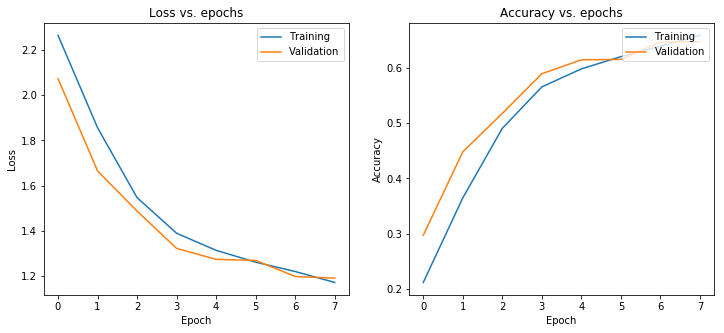

In [19]:
def plot_learning_curves():
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    fig.add_subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    
plot_learning_curves()


In [20]:
model.evaluate(test_X, test_y, verbose=2)


26032/1 - 4s - loss: 1.1561 - accuracy: 0.6274 - mae: 0.0993


[1.2875631813191166, 0.6274201, 0.09934455]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [21]:
model_cnn = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 1), padding='SAME', name = 'conv_1'),
    MaxPooling2D((2,2), name='pool_1'),
    Conv2D(8, (3,3), activation='relu', padding='SAME', name = 'conv_2'), 
    MaxPooling2D((2,2), name='pool_2'),
    Flatten(),
    Dense(64, activation='relu', name='dense_1'),
    Dropout(0.3),
    Dense(10, activation='softmax', name='dense_2')
])
model_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 8)         1160      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)               

In [22]:
model_cnn.compile(optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=['accuracy', 'mae'])


In [23]:
history = model_cnn.fit(train_X, train_y, batch_size=256, 
        validation_split=0.15, epochs=8, verbose=2,
        callbacks=[best_model_checkpoint, early_stopping_callback])


Train on 62268 samples, validate on 10989 samples
Epoch 1/8
62268/62268 - 149s - loss: 2.0763 - accuracy: 0.2605 - mae: 0.1701 - val_loss: 1.5074 - val_accuracy: 0.5595 - val_mae: 0.1434
Epoch 2/8
62268/62268 - 149s - loss: 1.1963 - accuracy: 0.6209 - mae: 0.1130 - val_loss: 0.8848 - val_accuracy: 0.7448 - val_mae: 0.0878
Epoch 3/8
62268/62268 - 146s - loss: 0.8889 - accuracy: 0.7274 - mae: 0.0850 - val_loss: 0.7306 - val_accuracy: 0.7949 - val_mae: 0.0743
Epoch 4/8
62268/62268 - 147s - loss: 0.7806 - accuracy: 0.7623 - mae: 0.0739 - val_loss: 0.6756 - val_accuracy: 0.8111 - val_mae: 0.0687
Epoch 5/8
62268/62268 - 150s - loss: 0.7139 - accuracy: 0.7816 - mae: 0.0675 - val_loss: 0.5980 - val_accuracy: 0.8250 - val_mae: 0.0581
Epoch 6/8
62268/62268 - 146s - loss: 0.6739 - accuracy: 0.7952 - mae: 0.0632 - val_loss: 0.5754 - val_accuracy: 0.8327 - val_mae: 0.0553
Epoch 7/8
62268/62268 - 148s - loss: 0.6431 - accuracy: 0.8040 - mae: 0.0605 - val_loss: 0.5544 - val_accuracy: 0.8378 - val_mae

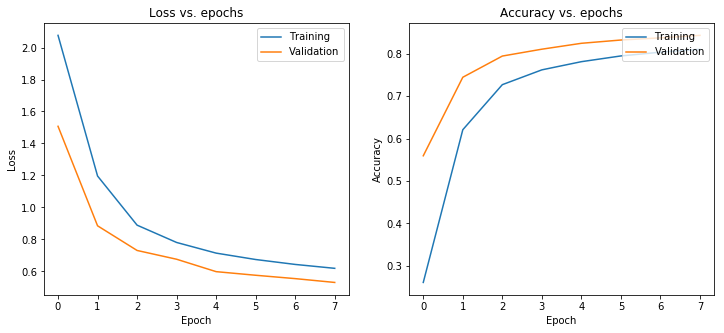

In [24]:
plot_learning_curves()


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [25]:
model_cnn.load_weights('best_model')


In [26]:
def print_random_samples(num_samples, data_X, data_y, data_y_sparse):
    random_index = np.random.choice(data_X.shape[0], num_samples)
    random_test_images = data_X[random_index, ...]
    random_test_labels = data_y_sparse[random_index, ...]
    predictions = model_cnn.predict(random_test_images)
    for i in range(0, num_samples):
        img = random_test_images[i]
        label = random_test_labels[i]
        prediction = predictions[i]
        pred_label = prediction.argmax() + 1
        pred_prob = prediction[pred_label - 1]
        print(f"Test Sample with Label {label}")
        fig = plt.figure(figsize=(12, 5))
        fig.add_subplot(121)
        plt.imshow(img[:, :, 0], cmap='gray')
        ax2 = fig.add_subplot(122)
        ax2.set_xticks(np.arange(len(prediction)+1))
        plt.bar(list(range(1,11)), prediction, color='blue')
        # plt.hist(prediction, bins=10, histtype='bar', rwidth=0.8)
        plt.xlabel('Digits')
        plt.ylabel('Prediction Weights')
        plt.title(f"Predicted {pred_label} with Probability {pred_prob:0.2f} for Label {label}")
        plt.show()

Test Sample with Label 7


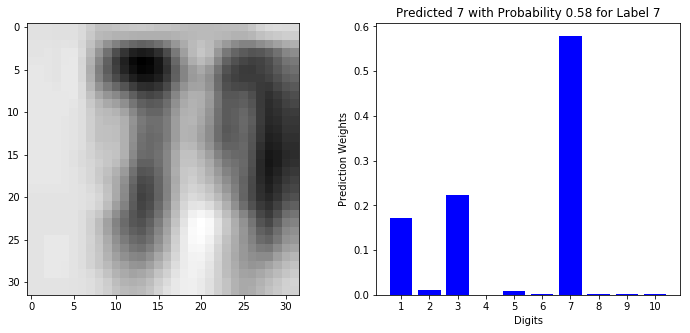

Test Sample with Label 4


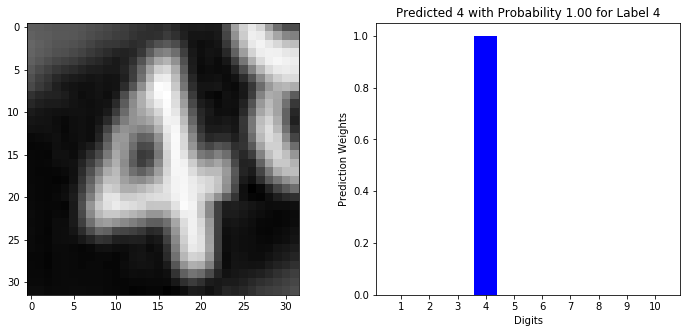

Test Sample with Label 1


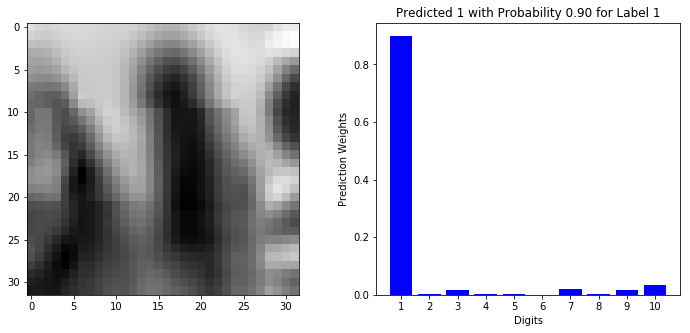

Test Sample with Label 5


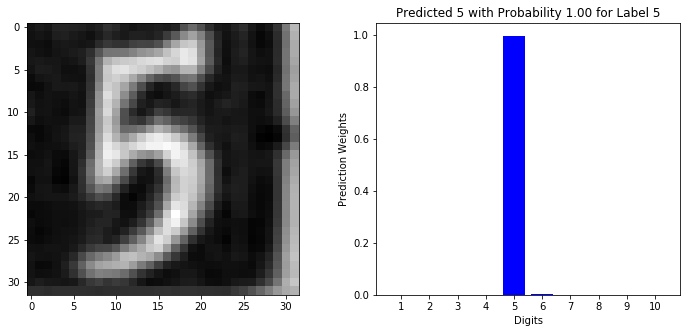

Test Sample with Label 1


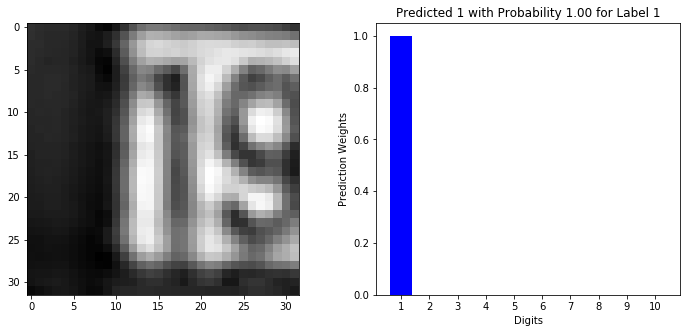

In [27]:
print_random_samples(5, test_X, test_y, test_y_sparse)